In [1]:
import os
import pandas as pd
from datetime import datetime as dt
import pickle
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [2]:
root = os.path.abspath(os.path.join(os.getcwd(),'..'))

In [3]:
reservoirs = ['harangi','kabini','krishnaraja_sagar','bhadra','lower_bhawani','hemavathy']

In [4]:
dfs = {r:pd.read_csv(os.path.join(root,'wave2web_data','refresh_09-27',f'{r}_2021-09-27.csv')).set_index('date') for r in reservoirs}

In [5]:
# make a dt index
for kk in dfs.keys():
    dfs[kk].index = pd.to_datetime(dfs[kk].index)

In [6]:
for kk in dfs.keys():
    # fill missing dates with nan
    dfs[kk] = pd.merge(
        pd.DataFrame(index=pd.date_range(dfs[kk].index.min(), dfs[kk].index.max(), freq='1D')),
        dfs[kk], 
        how='left',
        left_index=True, 
        right_index=True
    )

In [7]:
# drop corrupt tape data
for kk in dfs.keys():
    dfs[kk] = dfs[kk].loc[((dfs[kk].index<dt(2016,11,1)) | (dfs[kk].index>=dt(2017,11,1))),:]

In [8]:
# drop the max data
for kk in dfs.keys():
    most_recent_valid = dfs[kk].loc[~dfs[kk].isna().any(axis=1)].index.max()
    
    dfs[kk] = dfs[kk].loc[dfs[kk].index<=most_recent_valid,:]

In [9]:
# interp nan
for kk in dfs.keys():
    dfs[kk] = dfs[kk].interpolate(limit_direction='both',limit_area='inside',axis=0)

In [10]:
# z-score data
records = {}
for kk in dfs.keys():
    records[kk] = {
        'mean':dfs[kk].mean().to_dict(),
        'std':dfs[kk].std().to_dict(),
    }
    
    dfs[kk] = (dfs[kk] - dfs[kk].mean())/dfs[kk].std()/3
    
pickle.dump(records, open(os.path.join(root,'wave2web_data',f'3zscore_refresh_params.pkl'),'wb'))


In [11]:
### trn-test-val split

In [12]:
baseline_yrmnths = dfs['kabini'].index.astype(str).str[0:7].unique()[2:].tolist()

In [13]:
chosen_months = []
baseline_yrmnths = dfs['kabini'].index.astype(str).str[0:7].unique()[2:].tolist()
# need 3 months ahead for training
baseline_yrmnths = [el for el in baseline_yrmnths if el not in ['2021-06','2021-07','2021-08','2021-09','2016-08','2016-09','2016-10','2017-11','2017-12']]
deploy_yrmnths = baseline_yrmnths + ['2021-06','2021-07','2021-08','2021-09']
# want a 3 month window...
available_yrmnths = [el for el in baseline_yrmnths if el not in ['2021-04','2021-05','2016-06','2016-07']]
yrmnth_idxs = range(len(available_yrmnths))
# select 9+9 start months randomly
for ii in range(18):
    chosen_month = np.random.choice(yrmnth_idxs)
    chosen_months.append(chosen_month)
    yrmnth_idxs = [m for m in yrmnth_idxs if m not in range(chosen_month, chosen_month+3)]
    print(chosen_month, len(yrmnth_idxs))

113 113
87 110
56 107
81 104
38 101
27 98
48 95
42 92
32 89
91 86
85 84
102 81
15 78
69 75
72 72
4 69
12 66
0 63


In [14]:
val_yrmnths = np.array(available_yrmnths)[chosen_months[0:9]]
test_yrmnths = np.array(available_yrmnths)[chosen_months[9:]]

In [17]:
val_yrmnths, test_yrmnths

(array(['2021-03', '2019-01', '2014-11', '2018-07', '2013-05', '2012-06',
        '2014-03', '2013-09', '2012-11'], dtype='<U7'),
 array(['2019-05', '2018-11', '2020-04', '2011-06', '2015-12', '2016-03',
        '2010-07', '2011-03', '2010-03'], dtype='<U7'))

In [16]:
for kk in dfs.keys():
    dfs[kk]['yrmnth'] = dfs[kk].index.astype(str).str[0:7]
    dfs[kk]['set'] = np.nan
    dfs[kk].loc[dfs[kk]['yrmnth'].isin(baseline_yrmnths),'set'] = 'trn'

    for yrmnth in val_yrmnths:
        year, month = yrmnth.split('-')
        sdt = dt(int(year), int(month),1)
        edt = sdt + relativedelta(months=3)
        dfs[kk].loc[((dfs[kk].index>=sdt) & (dfs[kk].index<edt)),'set'] = 'val'
        
    for yrmnth in test_yrmnths:
        year, month = yrmnth.split('-')
        sdt = dt(int(year), int(month),1)
        edt = sdt + relativedelta(months=3)
        dfs[kk].loc[((dfs[kk].index>=sdt) & (dfs[kk].index<edt)),'set'] = 'test'

In [18]:
for kk in dfs.keys():
    dfs[kk].loc[pd.isna(dfs[kk]['set']) & dfs[kk]['yrmnth'].isin(deploy_yrmnths),'set']='deploy'

In [19]:
for kk in dfs.keys():
    dfs[kk].to_csv(os.path.join(root,'wave2web_data','refresh_09-27',f'{kk}_3zscore.csv'))

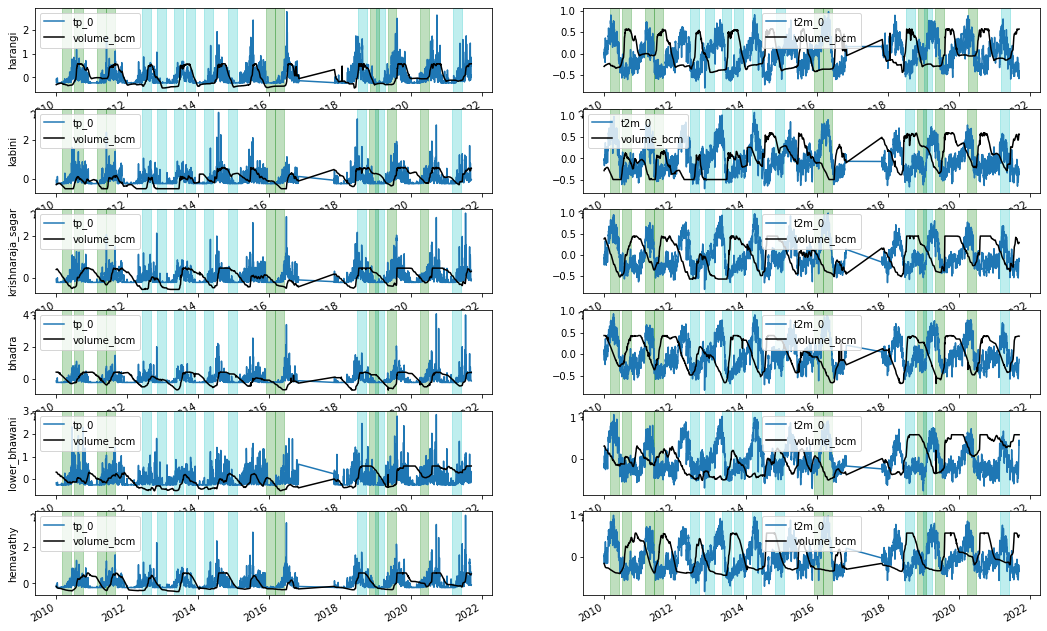

In [20]:
fig, axs = plt.subplots(6,2, figsize=(18,12))
for ii_k, (kk, df) in enumerate(dfs.items()):
    df[['tp_0']].plot(ax=axs[ii_k][0])
    df[['volume_bcm']].plot(ax=axs[ii_k][0], secondary_y='PRESENT_STORAGE_TMC', color='k')
    df[['t2m_0']].plot(ax=axs[ii_k][1])
    df[['volume_bcm']].plot(ax=axs[ii_k][1], secondary_y='PRESENT_STORAGE_TMC', color='k')
    axs[ii_k][0].set_ylabel(kk)
    
    for ii in range(2):
        for yrmnth in val_yrmnths:
            year, month = yrmnth.split('-')
            sdt = dt(int(year), int(month),1)
            edt = sdt + relativedelta(months=3)
            axs[ii_k][ii].axvspan(sdt, edt, color='c', alpha=0.25)

        for yrmnth in test_yrmnths:
            year, month = yrmnth.split('-')
            sdt = dt(int(year), int(month),1)
            edt = sdt + relativedelta(months=3)
            axs[ii_k][ii].axvspan(sdt, edt, color='g', alpha=0.25)
plt.show()

In [20]:
dfs['kabini']

,volume_bcm,tp_0,tp_1,tp_2,tp_3,tp_4,tp_5,tp_6,tp_7,tp_8,...,t2m_7,t2m_8,t2m_9,t2m_10,t2m_11,t2m_12,t2m_13,t2m_14,yrmnth,set
2010-01-01,-0.285396,-0.068856,-0.125995,-0.177733,-0.205791,-0.222993,-0.233381,-0.243278,-0.251418,-0.258326,...,-0.184370,-0.062128,-0.034188,0.131765,0.398899,0.133470,0.002556,0.212675,2010-01,NaN
2010-01-02,-0.275603,-0.231067,-0.236290,-0.249916,-0.259023,-0.262800,-0.268675,-0.273121,-0.240585,-0.170352,...,-0.269289,-0.196454,-0.203962,-0.144673,-0.129240,0.040059,0.008671,0.038126,2010-01,NaN
2010-01-03,-0.265810,-0.231461,-0.236499,-0.249747,-0.259731,-0.262865,-0.268163,-0.268533,-0.248250,-0.236040,...,0.021652,-0.059561,-0.220994,-0.273879,-0.087279,0.187669,0.202288,0.156324,2010-01,NaN
2010-01-04,-0.265810,-0.231461,-0.236478,-0.244722,-0.251304,-0.256376,-0.263608,-0.269273,-0.273569,-0.249445,...,0.118258,-0.152801,0.124906,0.141378,0.293819,0.246030,-0.064278,0.029328,2010-01,NaN
2010-01-05,-0.260913,-0.231461,-0.236499,-0.241327,-0.253121,-0.260798,-0.231521,-0.207519,-0.214034,-0.206340,...,0.104755,0.010066,0.051627,0.025682,0.347839,0.112806,0.192414,0.279452,2010-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-04,0.429494,0.344904,0.284681,0.548703,0.555488,0.525011,0.487159,0.422876,0.380603,0.350327,...,-0.212135,-0.171725,-0.260087,-0.249897,-0.183328,-0.139985,-0.148636,-0.096074,2021-09,deploy
2021-09-05,0.429494,0.469293,0.966062,0.825386,0.771262,0.700526,0.593347,0.515644,0.460003,0.428486,...,-0.207148,-0.224396,-0.234554,-0.251277,-0.208208,-0.102558,-0.087215,-0.134288,2021-09,deploy
2021-09-06,0.429494,0.806717,1.087130,0.910588,0.788624,0.639920,0.538898,0.495669,0.483719,0.455240,...,-0.266780,-0.211355,-0.182572,-0.123328,-0.093632,-0.068967,-0.027120,-0.120753,2021-09,deploy
2021-09-07,0.429494,0.420153,0.491261,0.382504,0.256324,0.185885,0.188222,0.196647,0.194400,0.189713,...,-0.229651,-0.182315,-0.134760,-0.118543,-0.116140,-0.064851,-0.012990,-0.133313,2021-09,deploy


In [23]:
test_df = pickle.load(open(os.path.join(root,'wave2web_data','kabini_3zscore_params.pkl'),'rb'))

In [24]:
test_df

{'harangi': {'mean': {'volume_bcm': 0.09533375602333326,
   'tp_0': 18.294667213240256,
   'tp_1': 59.372197580011466,
   'tp_2': 97.51311033247183,
   'tp_3': 135.3587957110185,
   'tp_4': 173.0963764350301,
   'tp_5': 210.595059461833,
   'tp_6': 248.73545124061442,
   'tp_7': 287.83093289065704,
   'tp_8': 326.7728160174804,
   'tp_9': 366.84615763284495,
   'tp_10': 394.18330892958977,
   'tp_11': 430.4171255461438,
   'tp_12': 471.54316231823293,
   'tp_13': 513.2732965900029,
   'tp_14': 555.8190690499396,
   't2m_0': 297.14031378661826,
   't2m_1': 296.63919131525233,
   't2m_2': 296.589010988914,
   't2m_3': 296.5536817695298,
   't2m_4': 296.5726878299788,
   't2m_5': 296.57350918567266,
   't2m_6': 296.5646036167266,
   't2m_7': 296.5447041067077,
   't2m_8': 296.5274210633267,
   't2m_9': 296.5219971242975,
   't2m_10': 296.78140990834305,
   't2m_11': 296.83927657040107,
   't2m_12': 296.8593261980609,
   't2m_13': 296.84700266294345,
   't2m_14': 296.8452358376466},
  'std

In [181]:
dfs['krishnaraja_sagar']['set']=='trn'

2010-01-01    False
2010-01-02    False
2010-01-03    False
2010-01-04    False
2010-01-05    False
              ...  
2021-09-04    False
2021-09-05    False
2021-09-06    False
2021-09-07    False
2021-09-08    False
Name: set, Length: 3943, dtype: bool

In [51]:
import pickle

In [53]:

df = pickle.load(open(os.path.join(root,'test.pkl'),'rb'))

In [61]:
dfs['kabini']

,volume_bcm,tp_0,tp_1,tp_2,tp_3,tp_4,tp_5,tp_6,tp_7,tp_8,...,t2m_7,t2m_8,t2m_9,t2m_10,t2m_11,t2m_12,t2m_13,t2m_14,yrmnth,set
2010-01-01,-0.285396,-0.068856,-0.125995,-0.177733,-0.205791,-0.222993,-0.233381,-0.243278,-0.251418,-0.258326,...,-0.184370,-0.062128,-0.034188,0.131765,0.398899,0.133470,0.002556,0.212675,2010-01,NaN
2010-01-02,-0.275603,-0.231067,-0.236290,-0.249916,-0.259023,-0.262800,-0.268675,-0.273121,-0.240585,-0.170352,...,-0.269289,-0.196454,-0.203962,-0.144673,-0.129240,0.040059,0.008671,0.038126,2010-01,NaN
2010-01-03,-0.265810,-0.231461,-0.236499,-0.249747,-0.259731,-0.262865,-0.268163,-0.268533,-0.248250,-0.236040,...,0.021652,-0.059561,-0.220994,-0.273879,-0.087279,0.187669,0.202288,0.156324,2010-01,NaN
2010-01-04,-0.265810,-0.231461,-0.236478,-0.244722,-0.251304,-0.256376,-0.263608,-0.269273,-0.273569,-0.249445,...,0.118258,-0.152801,0.124906,0.141378,0.293819,0.246030,-0.064278,0.029328,2010-01,NaN
2010-01-05,-0.260913,-0.231461,-0.236499,-0.241327,-0.253121,-0.260798,-0.231521,-0.207519,-0.214034,-0.206340,...,0.104755,0.010066,0.051627,0.025682,0.347839,0.112806,0.192414,0.279452,2010-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-04,0.429494,0.344904,0.284681,0.548703,0.555488,0.525011,0.487159,0.422876,0.380603,0.350327,...,-0.212135,-0.171725,-0.260087,-0.249897,-0.183328,-0.139985,-0.148636,-0.096074,2021-09,deploy
2021-09-05,0.429494,0.469293,0.966062,0.825386,0.771262,0.700526,0.593347,0.515644,0.460003,0.428486,...,-0.207148,-0.224396,-0.234554,-0.251277,-0.208208,-0.102558,-0.087215,-0.134288,2021-09,deploy
2021-09-06,0.429494,0.806717,1.087130,0.910588,0.788624,0.639920,0.538898,0.495669,0.483719,0.455240,...,-0.266780,-0.211355,-0.182572,-0.123328,-0.093632,-0.068967,-0.027120,-0.120753,2021-09,deploy
2021-09-07,0.429494,0.420153,0.491261,0.382504,0.256324,0.185885,0.188222,0.196647,0.194400,0.189713,...,-0.229651,-0.182315,-0.134760,-0.118543,-0.116140,-0.064851,-0.012990,-0.133313,2021-09,deploy


In [68]:
df = df.set_index(['level_0','prediction_dt']).drop(columns='level_1').unstack('level_0')

In [69]:
df.columns = df.columns.droplevel()

In [70]:
merge_df = pd.merge(
    df,
    dfs['kabini'][['volume_bcm']],
    how='left',
    left_index=True,
    right_index=True
)


In [78]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots()

In [84]:
merge_df[['volume_bcm','1 days']].isna().any(axis=1)

,volume_bcm,1 days
2010-03-02,False,False
2010-03-03,False,False
2010-03-04,False,False
2010-03-05,False,False
2010-03-06,False,False
...,...,...
2021-12-03,True,True
2021-12-04,True,True
2021-12-05,True,True
2021-12-06,True,True


<AxesSubplot:>

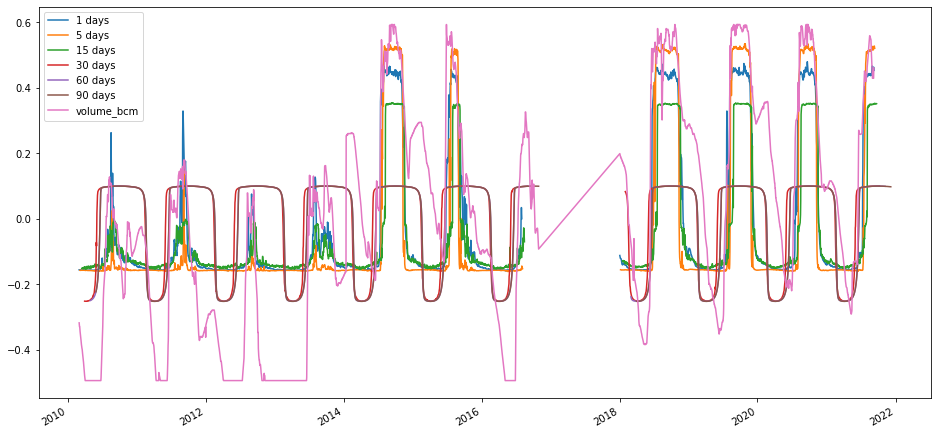

In [79]:
merge_df.plot(figsize=(16,8))

In [91]:
import glob, json

In [89]:
results_jsons = glob.glob(os.path.abspath(os.path.join(os.getcwd(),'..','w2w_results','*.json')))

In [93]:
data = {}
for f in results_jsons:
    kk = '_'.join(os.path.split(f)[-1].split('_')[:-1])
    print (kk)
    data[kk] = json.load(open(f,'r'))

lower_bhawani
bhadra
krishnaraja_sagar
hemavathy
kabini
harangi


In [97]:
df = pd.DataFrame(data).T

<AxesSubplot:>

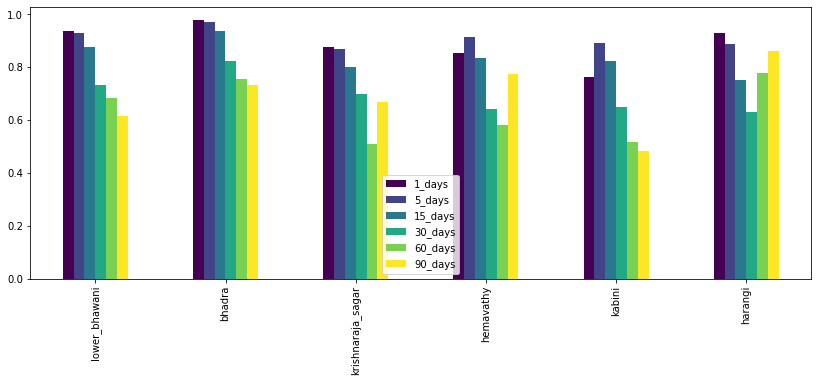

In [106]:
df.plot.bar(cmap='viridis', figsize=(14,5))